This notebook is designed for Spec2vec's validation for negative ionization mode.

For the validation GNPS_NIST14_MATCHES small spectral library is going to be used.

In [2]:
from matchms.importing import load_from_mgf
nist_lib = list(load_from_mgf('/home/ioannis/thesis_data/GNPS-NIST14-MATCHES.mgf'))
print('Number of spectra in the library: ', len(nist_lib))

Number of spectra in the library:  5763


Now we want to work only with spectra that have negative ionization mode.

In [3]:
from collections import Counter
ionmode = [spectrum.get('ionmode') for spectrum in nist_lib]
print(Counter(ionmode))

Counter({'positive': 5277, 'negative': 484, 'positive-20ev': 2})


In [4]:
# Filter only spectra with ionmode == "Negative"
negative_spectra = [s for s in nist_lib if s.get("ionmode") == "negative"]

print(f"Total spectra: {len(nist_lib)}")
print(f"Negative spectra: {len(negative_spectra)}")

Total spectra: 5763
Negative spectra: 484


In [5]:
# Further filter to only those with SMILES metadata
negative_with_smiles = [s for s in negative_spectra if s.get("smiles") is not None]
print("Negative spectra with SMILES:", len(negative_with_smiles))

Negative spectra with SMILES: 443


In [19]:
from matchms.exporting import save_as_mgf

save_as_mgf(negative_with_smiles, "/home/ioannis/thesis_data/GNPS-NIST14-MATCHES_neg.mgf")


dict_keys(['spectra'])


In [6]:
nist_lib_neg = list(load_from_mgf("/home/ioannis/thesis_data/GNPS-NIST14-MATCHES_neg.mgf")) 
print("Loaded spectra:", len(nist_lib_neg))

Loaded spectra: 443


In [7]:
import gensim
from matchms import calculate_scores
from spec2vec import Spec2Vec

In [8]:
spec2vec_model = ("/home/ioannis/MS2LDA/MS2LDA/Add_On/Spec2Vec/model_negative_mode/061125_s2v_filtered_neg.model") 
model = gensim.models.Word2Vec.load(spec2vec_model)

For Spec2Vec to work, the intensities need to be normalized!

In [9]:
from matchms.filtering.default_pipelines import DEFAULT_FILTERS
from matchms import SpectrumProcessor
processor = SpectrumProcessor(DEFAULT_FILTERS)

In [10]:
nist_cleaned_neg, _ = processor.process_spectra(nist_lib_neg)
nist_cleaned_neg = [s for s in nist_cleaned_neg if s is not None]

Processing spectra:  34%|███▍      | 152/443 [00:01<00:02, 130.29it/s]

2025-12-01 13:11:39,488:WARNING:matchms:clean_adduct:The charge in the adduct: [M-2H]2- and the given charge: -1 do not match


Processing spectra:  87%|████████▋ | 385/443 [00:03<00:00, 96.02it/s] 

2025-12-01 13:11:41,536:WARNING:matchms:clean_adduct:The charge in the adduct: [M-2H]2- and the given charge: -1 do not match


Processing spectra: 100%|██████████| 443/443 [00:03<00:00, 117.23it/s]


In [28]:
save_as_mgf(nist_cleaned_neg, "/home/ioannis/thesis_data/GNPS-NIST14-MATCHES_neg_cleaned.mgf")

dict_keys(['spectra'])


In [11]:
from spec2vec import SpectrumDocument
reference_documents = [SpectrumDocument(s, n_decimals=2) for s in nist_cleaned_neg]

In [12]:
print(len(reference_documents))

443


Now for a sanity check I will use the first spectrum as a query and take the best 10 candidates proposed by Spec2Vec

In [13]:
# Pick the first spectrum as query
query = nist_cleaned_neg[1]

# Remove the query from the list of spectra
spectra_excl = [s for s in nist_cleaned_neg if s is not query]

# Convert the remaining spectra into SpectrumDocuments
reference_documents_excl = [SpectrumDocument(s, n_decimals=2) for s in spectra_excl]


In [14]:
print("Query compound:", query.get("compound_name"), query.get("precursor_mz"))


Query compound: 1-Stearoyl-2-linoleoyl-sn-glycero-3-phosphoethanolamine 742.54


In [15]:
print(len(reference_documents_excl))

442


In [16]:
spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5, allowed_missing_percentage=5.0)
# As input calculate scores needs a list of spectra, so now that query is only one still has to be in [ ]
spec2vec_scores = calculate_scores(reference_documents_excl, [query], spec2vec_similarity)

2025-12-01 13:12:20,744:WARNING:spec2vec:vector_operations:('Missing percentage (8.02%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 13:12:20,749:WARNING:spec2vec:vector_operations:('Missing percentage (8.25%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 13:12:20,760:WARNING:spec2vec:vector_operations:('Missing percentage (33.80%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')


2025-12-01 13:12:20,778:WARNING:spec2vec:vector_operations:('Missing percentage (14.61%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 13:12:20,794:WARNING:spec2vec:vector_operations:('Missing percentage (6.68%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 13:12:20,797:WARNING:spec2vec:vector_operations:('Missing percentage (7.45%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 13:12:20,800:WARNING:spec2vec:vector_operations:('Missing percentage (7.40%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 13:12:20,804:WARNING:spec2vec:vector_operations:('Missing percentage (6.07%)

In [17]:
print(spec2vec_scores)

StackedSparseArray array of shape (442, 1, 1) containing scores for ('Spec2Vec',).


In [19]:
import numpy as np

# Collect all scores for your query
all_scores = spec2vec_scores.scores_by_query(query, sort=True)

# Count how many are NaN
nan_count = sum(1 for _, score in all_scores if score is None or np.isnan(score))
valid_count = len(all_scores) - nan_count

print(f"Empty/NaN vectors: {nan_count} / {len(all_scores)}")
print(f"Valid vectors: {valid_count} / {len(all_scores)}")


Empty/NaN vectors: 36 / 442
Valid vectors: 406 / 442


I get 36 Warnings about "missing percentage above 5%", meaning that 36 spectra were missing too many of peaks/words from the model's vocabulary. But 447 were fine, so almost 93%.

In [20]:
# Remove NaN/None scores
valid_scores = [(ref_doc, score) for ref_doc, score in all_scores
                if score is not None and not np.isnan(score)]

# Sort by score descending again
valid_scores.sort(key=lambda x: x[1], reverse=True)

# Now take the top-10 valid matches
best_matches = valid_scores[:10]


In [21]:
print("Query compound:", query.get("compound_name"), query.get("precursor_mz"))


Query compound: 1-Stearoyl-2-linoleoyl-sn-glycero-3-phosphoethanolamine 742.54


In [22]:
doc_to_spec = {}

for doc, spec in zip(reference_documents_excl, spectra_excl):
    doc_to_spec[doc] = spec   # link each document to its spectrum

# Step 3: Use the dictionary to look up the spectrum for a match
top_doc = best_matches[0][0]          # first SpectrumDocument from your top matches
ref_spec = doc_to_spec[top_doc]       # get the corresponding Spectrum
print(ref_spec.get("compound_name"), ref_spec.get("precursor_mz"))


1-Palmitoyl-2-oleoyl-sn-glycero-3-phosphate 673.485


Building MACCS fingerprint for the query

In [23]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys, DataStructs

query_smiles = query.get("smiles")
query_mol = Chem.MolFromSmiles(query_smiles) if query_smiles else None

if query_mol:
    Chem.SanitizeMol(query_mol)  # normalize valence/aromaticity
    fp_query = MACCSkeys.GenMACCSKeys(query_mol)
else:
    raise ValueError("Query SMILES missing or invalid")

In [24]:
print("Query compound:", query.get("compound_name"), query.get("precursor_mz"))

top_doc, top_score = best_matches[0]
ref_spec = doc_to_spec[top_doc]
print("Top Spec2Vec match:", ref_spec.get("compound_name"), top_score)


Query compound: 1-Stearoyl-2-linoleoyl-sn-glycero-3-phosphoethanolamine 742.54
Top Spec2Vec match: 1-Palmitoyl-2-oleoyl-sn-glycero-3-phosphate 0.5341860865855095


In [25]:
print(best_matches)

[(<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a15891040>, 0.5341860865855095), (<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a15892d20>, 0.47826821513691176), (<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a15880110>, 0.47457834094833773), (<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a158835c0>, 0.4723814129426019), (<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a15891b50>, 0.46171091254236346), (<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a158837d0>, 0.4585340373324013), (<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a15891670>, 0.43671188063794214), (<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a158929f0>, 0.43354425854706546), (<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a15872210>, 0.4301071318046454), (<spec2vec.SpectrumDocument.SpectrumDocument object at 0x731a15882360>, 0.4144859773204328)]


Building fingerprints for the best 5 and worst 5 spec2vec's candidates

In [26]:
best5 = valid_scores[:5]    # top 5 matches
worst5 = valid_scores[-5:]  # bottom 5 matches

In [27]:
def mol_from_smiles(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        Chem.SanitizeMol(mol)  # normalize valence/aromaticity
    return mol

def fp_maccs(mol):
    return MACCSkeys.GenMACCSKeys(mol)

def tanimoto(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [ ]:
def evaluate_matches(matches, label):
    scores = []
    for doc, s2v_score in matches:
        spec = doc_to_spec[doc]
        smi = spec.get("smiles")
        mol = mol_from_smiles(smi) if smi else None
        if mol:
            fp_ref = fp_maccs(mol)
            t = tanimoto(fp_query, fp_ref)
            scores.append(t)
            print(f"{label} | {spec.get('compound_name')} | Spec2Vec={s2v_score:.3f} | MACCS={t:.3f}")
        else:
            print(f"{label} | {spec.get('compound_name')} | Spec2Vec={s2v_score:.3f} | MACCS=N/A")
    return scores

In [29]:
# Evaluate best and worst 5
best5_scores = evaluate_matches(best5, "Best")
worst5_scores = evaluate_matches(worst5, "Worst")

Best | 1-Palmitoyl-2-oleoyl-sn-glycero-3-phosphate | Spec2Vec=0.534 | MACCS=0.784
Best | 1-Octadecanoyl-2-(4Z,7Z,10Z,13Z,16Z,19Z-docosahexaenoyl)-sn-glycero-3-phosphoethanolamine | Spec2Vec=0.478 | MACCS=1.000
Best | 1,2-Dioleoyl-sn-glycero-3-phosphoethanolamine-N-methyl | Spec2Vec=0.475 | MACCS=0.833
Best | 1,2-Dioleoyl-sn-glycero-3-phosphoethanolamine-N,N-dimethyl | Spec2Vec=0.472 | MACCS=0.804
Best | 1-Octadecanoyl-2-(9Z-octadecenoyl)-sn-glycero-3-phospho-(1'-sn-glycerol) | Spec2Vec=0.462 | MACCS=0.824
Worst | 2'-Deoxyuridine 5'-monophosphate | Spec2Vec=-0.098 | MACCS=0.432
Worst | L-Tryptophan | Spec2Vec=-0.101 | MACCS=0.266
Worst | Leu-Leu | Spec2Vec=-0.103 | MACCS=0.356
Worst | L-Glutamine | Spec2Vec=-0.112 | MACCS=0.393
Worst | D-(-)-Tagatose | Spec2Vec=-0.117 | MACCS=0.385


In [30]:
print("\nMedian Tanimoto (Best 5):", np.median(best5_scores))
print("Median Tanimoto (Worst 5):", np.median(worst5_scores))


Median Tanimoto (Best 5): 0.8235294117647058
Median Tanimoto (Worst 5): 0.38461538461538464


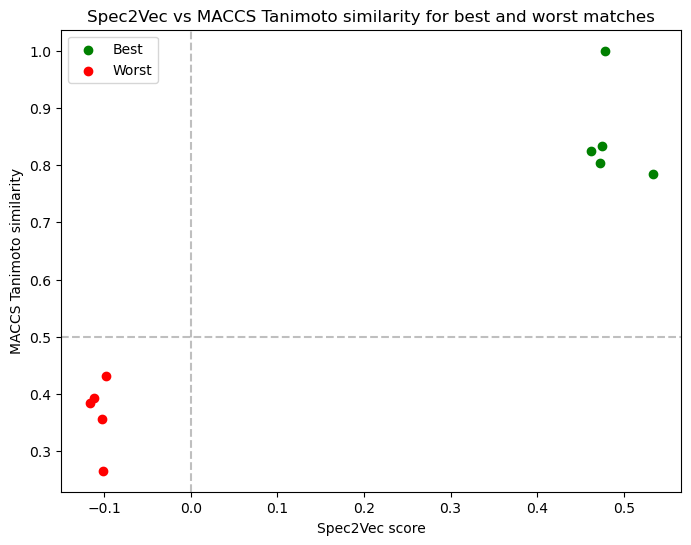

In [31]:
import matplotlib.pyplot as plt

best = [
    ("1-Palmitoyl-2-oleoyl-sn-glycero-3-phosphate", 0.534, 0.784),
    ("PE-DHA", 0.478, 1.000),
    ("PE-N-methyl", 0.475, 0.833),
    ("PE-N,N-dimethyl", 0.472, 0.804),
    ("PG-oleoyl", 0.462, 0.824),
]

worst = [
    ("dUMP", -0.098, 0.432),
    ("L-Tryptophan", -0.101, 0.266),
    ("Leu-Leu", -0.103, 0.356),
    ("L-Glutamine", -0.112, 0.393),
    ("Tagatose", -0.117, 0.385),
]

# Plot
plt.figure(figsize=(8,6))
for name, s2v, maccs in best:
    plt.scatter(s2v, maccs, color="green", label="Best" if name==best[0][0] else "")
for name, s2v, maccs in worst:
    plt.scatter(s2v, maccs, color="red", label="Worst" if name==worst[0][0] else "")

plt.axhline(0.5, color="gray", linestyle="--", alpha=0.5)
plt.axvline(0, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Spec2Vec score")
plt.ylabel("MACCS Tanimoto similarity")
plt.title("Spec2Vec vs MACCS Tanimoto similarity for best and worst matches")
plt.legend()
plt.show()

It is also important to check more than just one query to check the robustness. In order to do so, first I want to check if there are many duplicates in the library that can skew the best matches suggested by Spec2Vec.

In [32]:
inchikeys = [spec.get("inchikey") for spec in nist_cleaned_neg if spec.get("inchikey")]
unique_inchikeys = set(inchikeys)
print(f"Total spectra: {len(inchikeys)}") 
print(f"Unique InChIKeys: {len(unique_inchikeys)}")

Total spectra: 443
Unique InChIKeys: 219


In [33]:
counts = Counter(inchikeys)

# Find the most common InChIKey
most_common_ik, freq = counts.most_common(1)[0]

print(f"Most common InChIKey: {most_common_ik}")
print(f"Number of spectra: {freq}")

Most common InChIKey: WBIQQQGBSDOWNP-UHFFFAOYSA-N
Number of spectra: 11


In [34]:
from collections import defaultdict

groups = defaultdict(list)

for spec in nist_cleaned_neg:  
    ik_block = (spec.get("inchikey")) #.split("-")[0]
    adduct = spec.get("adduct")
    if not ik_block or not adduct:
        continue
    key = (ik_block, adduct)
    groups[key].append(spec)

# Report group sizes
print(f"Total groups: {len(groups)}")
print("Top 10 most common groups:")
for key, spectra in sorted(groups.items(), key=lambda x: len(x[1]), reverse=True)[:10]:
    print(f"{key}: {len(spectra)} spectra")

Total groups: 230
Top 10 most common groups:
('WBIQQQGBSDOWNP-UHFFFAOYSA-N', '[M-H]-'): 11 spectra
('UAZLASMTBCLJKO-UHFFFAOYSA-N', '[M-H]-'): 10 spectra
('YDTWOEYVDRKKCR-KNERPIHHSA-N', '[M-H]-'): 8 spectra
('XVYPOHCSLJZFED-QZEVRULJSA-N', '[M-H]-'): 8 spectra
('BXFFHSIDQOFMLE-UHFFFAOYSA-N', '[M-H]-'): 7 spectra
('PAZGBAOHGQRCBP-DDDNOICHSA-N', '[M-H]-'): 7 spectra
('BBYWOYAFBUOUFP-JOCHJYFZSA-N', '[M-H]-'): 6 spectra
('OPJZLUXFQFQYAI-GNPVFZCLSA-N', '[M-H]-'): 6 spectra
('ANRKEHNWXKCXDB-BHFWLYLHSA-N', '[M-H]-'): 6 spectra
('DRIVXEVMDWCWLI-CAQMIEAISA-N', '[M-H]-'): 6 spectra


It is obvious that there are some duplicates in the dataset, so in order to make the validation of Spec2Vec as clear and less redundant as possible, only one representative of each group will be selected and in order to make it reproducable the first spectra from each group will be selected.

In [35]:
deduplicated_spectra = [spectra[0] for spectra in groups.values()]
print(f"Total spectra before deduplication: {len(nist_cleaned_neg)}")
print(f"Total groups (InChIKey  + adduct): {len(groups)}")
print(f"Deduplicated spectra: {len(deduplicated_spectra)}")

Total spectra before deduplication: 443
Total groups (InChIKey  + adduct): 230
Deduplicated spectra: 230


In [36]:
def prepare_query(query_spec):
    """
    Prepare the query spectrum for validation.
    Returns the query fingerprint (MACCS).
    """
    query_smiles = query_spec.get("smiles")
    if not query_smiles:
        raise ValueError("Query SMILES missing")
    query_mol = mol_from_smiles(query_smiles)
    fp_query = fp_maccs(query_mol)

    return fp_query

In [37]:
def exclude_query_from_library(query, library):
    """Return library without the exact query spectrum."""
    q_id = query.get("spectrum_id")
    library_excl = [spec for spec in library if spec.get("spectrum_id") != q_id]
    return library_excl

In [ ]:
import pandas as pd

def summarize_top_bottom(query_spec, spec2vec_scores, fp_query, spec_to_meta, label="Query"):
    """
    Accepts Spec2Vec scores as (Spectrum, Spectrum, [score]) tuples.
    Looks up metadata directly from spec_to_meta keyed by Spectrum.
    """
    rows = []
    for reference, query, scores in spec2vec_scores:
        s2v_score = scores[0]

        if pd.isna(s2v_score):
            continue

        if reference not in spec_to_meta:
            continue

        spec = spec_to_meta[reference]
        smi = spec.get("smiles")
        mol = mol_from_smiles(smi) if smi else None
        if mol:
            fp_ref = fp_maccs(mol)
            t = tanimoto(fp_query, fp_ref)
            rows.append({
                "cand_inchikey": spec.get("inchikey"),
                "cand_adduct": spec.get("adduct"),
                "spec2vec": s2v_score,
                "maccs": t
            })

    if not rows:
        print(f"{label} | No valid candidates found.")
        return {
            "query_id": query_spec.get("spectrum_id"),
            "top5_maccs_median": float("nan"),
            "bottom5_maccs_median": float("nan"),
            "median_diff": float("nan"),
            "n_candidates": 0
        }

    df = pd.DataFrame(rows).sort_values("spec2vec", ascending=False)

    top5 = df.head(5)["maccs"].median() if len(df) >= 5 else float("nan")
    bottom5 = df.tail(5)["maccs"].median() if len(df) >= 5 else float("nan")
    diff = top5 - bottom5 if pd.notna(top5) and pd.notna(bottom5) else float("nan")

    print(f"{label} | Top-5 median MACCS={top5:.3f}, Bottom-5 median MACCS={bottom5:.3f}, Diff={diff:.3f}")

    return {
        "query_id": query_spec.get("spectrum_id"),
        "top5_maccs_median": top5,
        "bottom5_maccs_median": bottom5,
        "median_diff": diff,
        "n_candidates": len(df)
    }





In [51]:
results = []

for i, query in enumerate(deduplicated_spectra[:30]):
    print(f"\n--- Running Query {i+1} ---")

    # Step 1: exclude query from library
    library_excl = exclude_query_from_library(query, deduplicated_spectra)

    # Step 2: build dictionary keyed by Spectrum
    spec_to_meta = {spec: spec for spec in library_excl}

    # Step 3: compute Spec2Vec scores (returns Spectrum, Spectrum, [score])
    spec2vec_scores = calculate_scores(library_excl, [query], spec2vec_similarity)

    # Step 4: prepare query fingerprint
    fp_query = prepare_query(query)

    # Step 5: evaluate top-5 vs bottom-5
    result = summarize_top_bottom(query, spec2vec_scores, fp_query, spec_to_meta, label=f"Query {i+1}")
    results.append(result)

# Step 6: aggregate results across queries
import pandas as pd
summary = pd.DataFrame(results)

print("\nAggregate stats:")
print(summary.describe())

fraction_enriched = (summary["median_diff"] > 0).mean()
print(f"\nFraction of queries enriched (top-5 > bottom-5): {fraction_enriched:.2f}")



--- Running Query 1 ---
2025-12-01 14:16:48,064:WARNING:spec2vec:vector_operations:('Missing percentage (8.02%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 14:16:48,076:WARNING:spec2vec:vector_operations:('Missing percentage (33.80%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 14:16:48,112:WARNING:spec2vec:vector_operations:('Missing percentage (14.61%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 14:16:48,137:WARNING:spec2vec:vector_operations:('Missing percentage (7.45%) is above set maximum. An empty vector will be returned.', 'Consider retraining the used model or change the `allowed_missing_percentage`.')
2025-12-01 14:16:48,145:WARNING:spec2vec:vector_operations:('

/tmp/ipykernel_1137/124942969.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Group", y="MACCS_median", data=plot_df, palette="Set2")


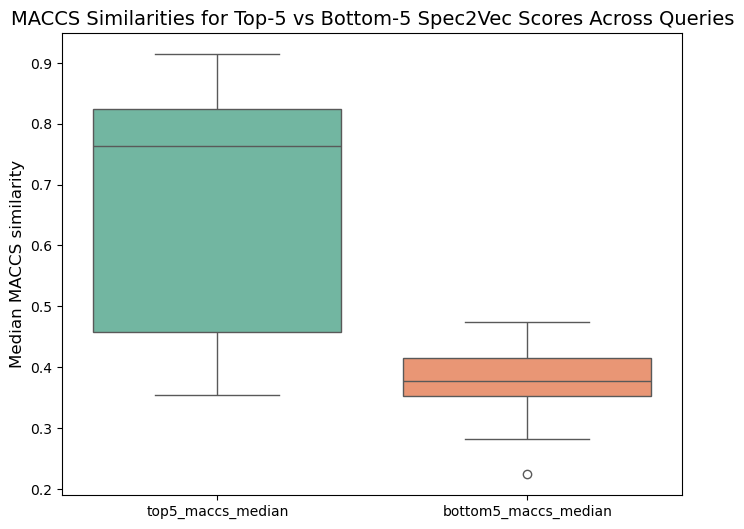

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape summary DataFrame for plotting
plot_df = summary.melt(
    value_vars=["top5_maccs_median", "bottom5_maccs_median"],
    var_name="Group", value_name="MACCS_median"
)

plt.figure(figsize=(8,6))
sns.boxplot(x="Group", y="MACCS_median", data=plot_df, palette="Set2")

plt.title("MACCS Similarities for Top-5 vs Bottom-5 Spec2Vec Scores Across Queries", fontsize=14)
plt.ylabel("Median MACCS similarity", fontsize=12)
plt.xlabel("")
plt.show()


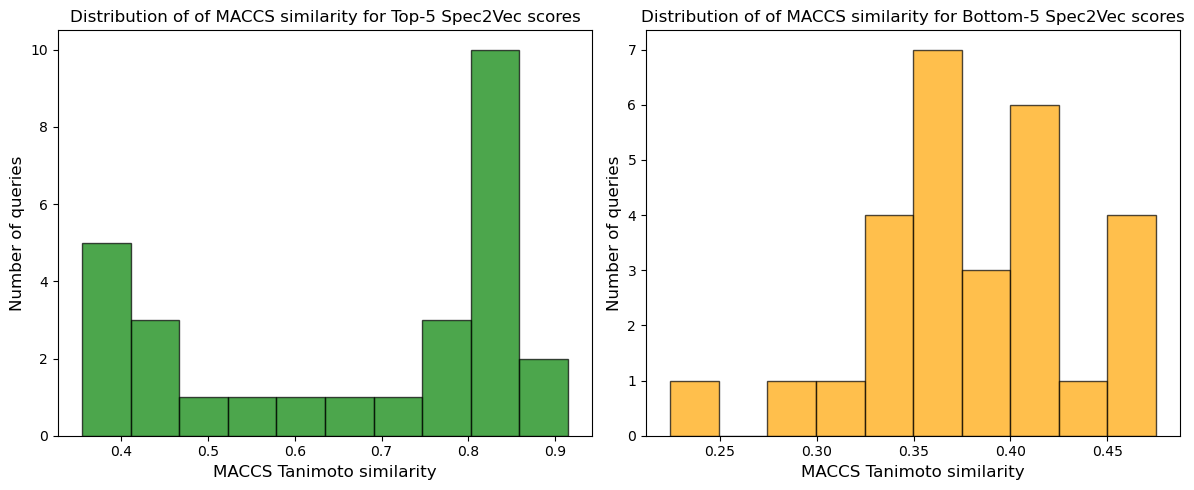

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Histogram for Top-5 median MACCS
plt.subplot(1,2,1)
plt.hist(summary["top5_maccs_median"].dropna(), bins=10, edgecolor="black", alpha=0.7, color="green")
plt.xlabel("MACCS Tanimoto similarity", fontsize=12)
plt.ylabel("Number of queries", fontsize=12)
plt.title("Distribution of of MACCS similarity for Top-5 Spec2Vec scores")

# Histogram for Bottom-5 median MACCS
plt.subplot(1,2,2)
plt.hist(summary["bottom5_maccs_median"].dropna(), bins=10, edgecolor="black", alpha=0.7, color="orange")
plt.xlabel("MACCS Tanimoto similarity", fontsize=12)
plt.ylabel("Number of queries", fontsize=12)
plt.title("Distribution of of MACCS similarity for Bottom-5 Spec2Vec scores")

plt.tight_layout()
plt.show()


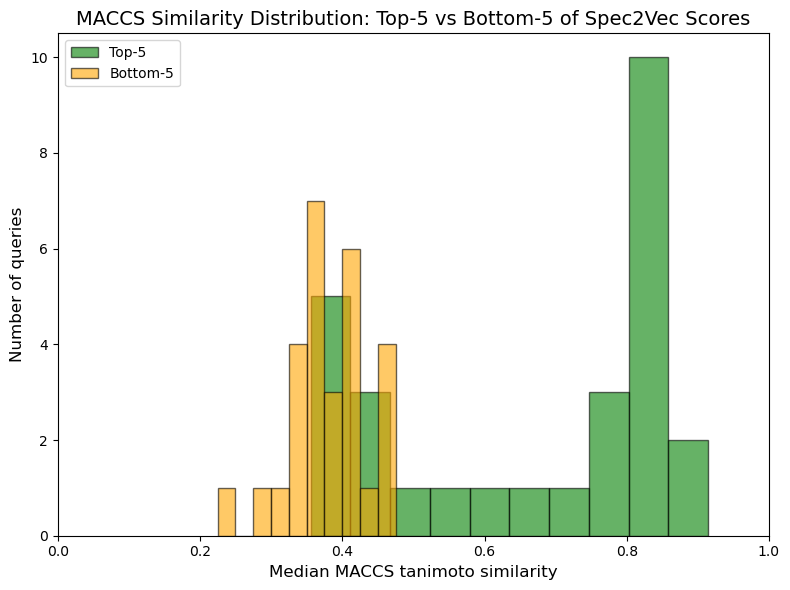

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Plot both histograms on the same axes
plt.hist(summary["top5_maccs_median"].dropna(), bins=10, alpha=0.6, label="Top-5", color="green", edgecolor="black")
plt.hist(summary["bottom5_maccs_median"].dropna(), bins=10, alpha=0.6, label="Bottom-5", color="orange", edgecolor="black")

# Formatting
plt.xlabel("Median MACCS tanimoto similarity", fontsize=12)
plt.ylabel("Number of queries", fontsize=12)
plt.title("MACCS Similarity Distribution: Top-5 vs Bottom-5 of Spec2Vec Scores", fontsize=14)
plt.legend()
plt.xlim(0, 1)  # Force scale from 0 to 1

plt.tight_layout()
plt.show()
